In [2]:
%load_ext autoreload
%autoreload 2
# Set-up: Import numpy and assign GPU


import os
os.environ['TRANSFORMERS_CACHE'] = '/local/helenl/.cache/'
os.environ['PYTORCH_TRANSFORMERS_CACHE'] = '/local/helenl/.cache/'

from collections import defaultdict


import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from tqdm.notebook import tqdm

from gpu_utils import restrict_GPU_pytorch
restrict_GPU_pytorch('0')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'restrict_GPU_pytorch'

In [2]:
# Load Amazon WILDS pre-trained model

import statistics
import sys
import pickle
import numpy as np
import pandas as pd
import statistics


import torch
import torchvision.transforms as transforms

import argparse
import pdb

from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds.common.grouper import CombinatorialGrouper
from transforms_helenl import initialize_transform, getBertTokenizer
from wordcloud import WordCloud

from wilds_base import predict_augment_labels

from wilds_civilcomments_base import calculate_accuracy, show_values, create_accuracy_graph

sys.path.insert(0, './wilds/examples/')
os.environ["MODEL_DIR"] = '/local/helenl/helenl/models/'
model_dir = '/local/helenl/helenl/models'

from algorithms.initializer import initialize_algorithm


ModuleNotFoundError: No module named 'wilds_civilcomments_base'

In [ ]:
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
set_seed(0)

In [ ]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
#config_dict = pickle.load(open('amazon_config.txt', 'rb'))



full_dataset = get_dataset(dataset='civilcomments', download=False, root_dir = './wilds/data')

In [3]:
def predict_augmented_labels(transform_name
                            , num_samples = 1
                            , aug_char_min = 1
                            , aug_char_max = 1
                            , aug_char_p = 1
                            , aug_word_min = 1
                            , aug_word_max = None
                            , aug_word_p = 0.1
                            , min_char = 4):

    # Grab config generated by WILDS library from txt file
    infile = open('civilcomments_config.txt','rb')
    new_dict = vars(pickle.load(infile))
    infile.close() 

    # Modify config with intended transformation
    new_dict['transform'] = transform_name

    # Create config with ERM algorithm
    config = Namespace(**new_dict)
    config.algorithm = 'ERM'

    
    # Generate training and evaluation transforms
    print("num_samples:", num_samples)
    train_transform = initialize_transform(transform_name=config.transform
                                          , config=config
                                          , dataset=full_dataset
                                          , is_training=True
                                          , num_samples = num_samples
                                          , aug_char_min = aug_char_min
                                          , aug_char_max = aug_char_max
                                          , aug_char_p = aug_char_p
                                          , aug_word_min = aug_word_min
                                          , aug_word_max = aug_word_max
                                          , aug_word_p = aug_word_p
                                          , min_char = min_char)
    
    # Prepare training data, loader, and grouper
    train_data = full_dataset.get_subset('train', transform=train_transform)
    train_loader = get_train_loader('standard', train_data, batch_size=64)
    train_grouper = CombinatorialGrouper(dataset=full_dataset, groupby_fields=config.groupby_fields)
    
    # Prepare training data, loader, and grouper
    eval_transform = initialize_transform(transform_name=config.transform
                                          , config=config
                                          , dataset=full_dataset
                                          , is_training=False
                                          , num_samples = num_samples
                                          , aug_char_min = aug_char_min
                                          , aug_char_max = aug_char_max
                                          , aug_char_p = aug_char_p
                                          , aug_word_min = aug_word_min
                                          , aug_word_max = aug_word_max
                                          , aug_word_p = aug_word_p
                                          , min_char = min_char
                                        )
    
    
    eval_data = full_dataset.get_subset('test', transform=eval_transform)
    #return (eval_data.indices, eval_data.dataset)    


    eval_loader = get_eval_loader('standard', eval_data, batch_size = 64)
    
    # CODE TAKEN FROM WILDS TRAINING SCRIPTS:
    datasets = defaultdict(dict)
    for split in full_dataset.split_dict.keys():
        if split=='train':
            transform = train_transform
            verbose = True
        elif split == 'val':
            transform = eval_transform
            verbose = True
        else:
            transform = eval_transform
            verbose = False
        # Get subset
        datasets[split]['dataset'] = full_dataset.get_subset(
            split,
            frac=config.frac,
            transform=transform)

        if split == 'train':
            datasets[split]['loader'] = get_train_loader(
                loader=config.train_loader,
                dataset=datasets[split]['dataset'],
                batch_size=config.batch_size,
                uniform_over_groups=config.uniform_over_groups,
                grouper=train_grouper,
                distinct_groups=config.distinct_groups,
                n_groups_per_batch=config.n_groups_per_batch,
            **config.loader_kwargs)
        else:
            datasets[split]['loader'] = get_eval_loader(
                loader=config.eval_loader,
                dataset=datasets[split]['dataset'],
                grouper=train_grouper,
                batch_size=config.batch_size,
                **config.loader_kwargs)

    # Set fields
    datasets[split]['split'] = split
    datasets[split]['name'] = full_dataset.split_names[split]
    datasets[split]['verbose'] = verbose

    # Loggers
    # datasets[split]['eval_logger'] = BatchLogger(
    #     os.path.join(config.log_dir, f'{split}_eval.csv'), mode=mode, use_wandb=(config.use_wandb and verbose))
    # datasets[split]['algo_logger'] = BatchLogger(
    #     os.path.join(config.log_dir, f'{split}_algo.csv'), mode=mode, use_wandb=(config.use_wandb and verbose))

    print(transform_name)
    print("initialize model")
    # Initiate model and run on training set
    alg = initialize_algorithm(config, datasets, train_grouper)
    
    # TODO: pytorch load pretrained weights
    #alg.model.load_state_dict(torch.load('./best_model.pth'))
    alg.load_state_dict(torch.load('./best_model.pth')['algorithm'])
    alg.model.cuda()
    
    print("initialization complete")
    
    
    print("generating predictions")
    it = iter(eval_loader)
    predictions = []
    labels = []
    metadata = []
    
    for batch in tqdm(it):
        #print(batch) # original batch is a list of tensors
        #pdb.set_trace()
        #print(len(batch[0]))
        #print(batch[1].shape) # 64 x 1
        #print(batch[2].shape) # 64 x 16
        for sample in batch[0]:
            #print(sample.shape)
            raw_pred = alg.model(sample.cuda()).cpu().detach().numpy()
            
            predictions.extend(raw_pred.tolist())
        
        for i in range(num_samples):
            labels.extend(batch[1].tolist())
            metadata.extend(batch[2].tolist()) # tensor of (64,16) for each batch

    
    
    print("writing predictions")
    #file_name = './ERM_word_frequency_experiment/' + transform_name + "_aug_size_" + str(aug_size) + ".npy"
    file_name = './data/ERM_word_num_samples_experiment/' + transform_name + "_num_samples_" + str(num_samples) + ".npy"
    #file_name = './ERM_char_frequency_experiment_2/word_p_' + str(aug_word_p) + transform_name + "_aug_size_" + str(aug_char_min) + ".npy"

    #parameters = locals()                      
    with open(file_name, 'wb+') as file:
        np.save(file, predictions)
        np.save(file, labels)
        np.save(file, metadata)
        #np.save(file, parameters)


    return (eval_data.indices, eval_data.dataset)    


In [12]:
predict_augmented_labels('nlp_random_word_delete'
                            , num_samples = 2
                            , aug_word_min = 1
                            , aug_word_max = 1
                            , aug_word_p = 1)

num_samples: 2
char_min: 1
word_p: 1
char_min: 1
word_p: 1
nlp_random_word_delete
initialize model


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertClassifier: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertClassifier were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN t

initialization complete
generating predictions


  0%|          | 0/2091 [00:00<?, ?it/s]

writing predictions


FileNotFoundError: [Errno 2] No such file or directory: './ERM_word_num_samples_experiment/nlp_random_word_delete_num_samples_2.npy'

In [6]:
def get_eval_dataset():
    """
    Returns a list of length 1 containing the indices of the WILDS dataset used to form the raw eval inputs. 
    
    """
    full_dataset = get_dataset(dataset='civilcomments', download=False, root_dir = './wilds/data')
    
    # Grab config generated by WILDS library from txt file
    infile = open('civilcomments_config.txt','rb')
    new_dict = vars(pickle.load(infile))
    infile.close() 


    # Create config with ERM algorithm
    config = Namespace(**new_dict)
    config.algorithm = 'ERM'
    
        # Prepare training data, loader, and grouper
    eval_transform = initialize_transform(transform_name=config.transform,
                                      config=config,
                                      dataset=full_dataset,
                                      is_training=False,
                                      aug_size = 1)
    
    eval_data = full_dataset.get_subset('test', transform=eval_transform)
    eval_indices = eval_data.indices.tolist()
    
    eval_inputs = [full_dataset[i] for i in eval_indices]
    return eval_inputs
        
        

In [49]:
eval_inputs = get_eval_dataset()


#eval_inputs = [full_dataset[i] for i in eval_indices]

eval_inputs

bert: 1


[('OH yes - Were those evil Christian Missionaries (many of whom were slaughtered by the Indians, or lost their lives due to disease, starvation etc.) lumped in with those "genocidists" you mention ? (yes I did make up a word, just as you make up stories).',
  tensor(1),
  tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1])),
 ("He's considered a good candidate for a cyber-security post? He couldn't even keep emails from his paramour secure.",
  tensor(0),
  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
 ("Lela, you admit no records exist to support your claims of a restrained religious hoard, but then state the atheists are worse? It's all bad, but it's all within human nature. If we can do away with any of the cults involved we might lessen future occurrences.",
  tensor(0),
  tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])),
 ("I'll take the iffy libertarian over the guy who endorsed Hillary in the last race which was Trump by the way .. All the morons sho

In [17]:
predict_augmented_labels('bert')

bert
initialize model


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertClassifier: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertClassifier were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN t

initialization complete
generating predictions


  0%|          | 0/2091 [00:00<?, ?it/s]

writing predictions


In [4]:
def calculate_accuracy(prediction_file, sampling_percent = 0.8, num_runs = 10):
    logit_predictions = []
    labels = []
    
    with open(prediction_file, 'rb') as file:
        logit_predictions = np.load(file, allow_pickle = True)
        labels = np.load(file, allow_pickle = True)

    accuracy_scores = []
    
    total_dp = len(logit_predictions) #133782
    
    num_subsamples = int(total_dp * sampling_percent) #107025 for 133782 data points

    for i in tqdm(range(num_runs)):
        random_indices = np.random.choice(np.arange(total_dp), size = num_subsamples, replace = False)

        rand_logit_predictions = np.take(logit_predictions, random_indices, axis = 0)
        matching_labels = np.take(labels, random_indices)
        #print("labels_length", len(matching_labels))
        #print("samples_length", rand_logit_predictions[0])
        
        classified_predictions = []
        for prediction in rand_logit_predictions:
            index_prediction = np.argmax(prediction, axis = 0).tolist()
            classified_predictions.append(index_prediction)
    
        score = sklearn.metrics.accuracy_score(matching_labels, classified_predictions)
        #print(score)
        accuracy_scores.append(score)
    
    return accuracy_scores

In [7]:
def calculate_recall(prediction_file):
    logit_predictions = []
    
    with open(prediction_file, 'rb') as file:
        logit_predictions = np.load(file)
        labels = np.load(file)
        
    #print(true_values)
    classified_predictions = []
    for prediction in logit_predictions:
        index_prediction = np.argmax(prediction, axis = 1).tolist()

        classified_predictions.extend(index_prediction)
            
    score = sklearn.metrics.recall_score(labels, classified_predictions)
    return score

In [5]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.3f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.3f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [21]:
def average_sample_accuracies(path_to_pred_file):
    
    num_samples = int(path_to_pred_file.split('_')[-1].split('.')[0])
    sample_group_averages = []
    sample_group_labels = []
    sample_group_metadata = []
    
    with open(path_to_pred_file, 'rb') as file:
        logit_predictions = np.load(file, allow_pickle = True)
        labels = np.load(file, allow_pickle = True)
        meta_data = np.load(file, allow_pickle = True)
        
    start = 0
    stop = num_samples
    
    while start < len(logit_predictions):
        sample_group = logit_predictions[start:stop]
        
        sample_logit_average = np.average(sample_group, axis = 0)
        sample_group_averages.append(sample_logit_average)
        
        start += num_samples
        stop += num_samples
    
    sample_group_labels = labels[::num_samples]
    sample_group_metadata = meta_data[::num_samples]
    
    
    assert start == len(logit_predictions), "sample batches incrementing incorrectly"

    assert len(sample_group_averages) == len(logit_predictions)/num_samples, "sample batches split incorrectly"
    
    assert len(sample_group_labels) == len(sample_group_averages), "label count does not match sample group count"
    
    assert len(sample_group_metadata) == len(sample_group_averages), "metadata count does not match sample group count"
    
    averaged_sample_group_file = path_to_pred_file.replace('raw', 'averaged_sample_group', 1)
    

    with open(averaged_sample_group_file, 'wb+') as file:
        np.save(file, sample_group_averages)
        np.save(file, sample_group_labels)
        np.save(file, sample_group_metadata)
        #np.save(file, parameters)

            

In [23]:
aug_file_dir = './data/ERM_word_num_samples_experiment/raw/'

for file in os.listdir(aug_file_dir):
    full_path = aug_file_dir + file
    
    if full_path.split('.')[-1] == 'npy':
        print(full_path)
        average_sample_accuracies(full_path)



./data/ERM_word_num_samples_experiment/raw/nlp_random_word_delete_num_samples_2.npy
./data/ERM_word_num_samples_experiment/raw/nlp_random_word_delete_num_samples_1.npy
./data/ERM_word_num_samples_experiment/raw/nlp_random_word_delete_num_samples_4.npy
./data/ERM_word_num_samples_experiment/raw/nlp_random_word_delete_num_samples_8.npy
./data/ERM_word_num_samples_experiment/raw/nlp_random_word_delete_num_samples_7.npy
./data/ERM_word_num_samples_experiment/raw/nlp_random_word_delete_num_samples_5.npy
./data/ERM_word_num_samples_experiment/raw/nlp_random_word_delete_num_samples_3.npy
./data/ERM_word_num_samples_experiment/raw/nlp_random_word_delete_num_samples_6.npy
./data/ERM_word_num_samples_experiment/raw/nlp_random_word_delete_num_samples_9.npy
./data/ERM_word_num_samples_experiment/raw/nlp_random_word_delete_num_samples_10.npy


In [43]:


"""
Create graph comparing accuracy of all supported augmentations

Parameters:
    augmentations: list of strings, each corresponding to a supported augmentation
    
"""

def create_accuracy_graph(augmentation_file_paths, plot_type = 'line'):
    
    aug_to_acc = []
    for file_name in augmentation_file_paths:

        accuracies = calculate_accuracy(file_name)
        num_samples = int(file_name.split('_')[-1].split('.')[0])
        
        for i in range(len(accuracies)):
            accuracy = accuracies[i]
            aug_dict = {"num_samples":num_samples, "accuracy": accuracy, "batch_num": i}
            aug_to_acc.append(aug_dict)

    
    acc_df = pd.DataFrame(aug_to_acc).sort_values('accuracy', ascending = False)
    print(acc_df)
    
    sns.set(font_scale = 2)
    fig, ax = plt.subplots()
    
    if plot_type == 'bar':
        p = sns.barplot(x = 'num_samples', y = 'accuracy', data = acc_df, ax = ax, ci = 95)
        
    elif plot_type == 'box':
        p = sns.boxplot(x = 'num_samples', y = 'accuracy', data = acc_df, ax = ax)#, order = acc_df['augmentation'])
    

    elif plot_type == 'line':
        acc_df = pd.DataFrame(aug_to_acc).sort_values("num_samples", ascending = False)
        p = sns.lineplot(x = "num_samples", y = "accuracy", data = acc_df, ax = ax)
        
        
    min_value = acc_df.min()['accuracy']
    max_value = acc_df.max()['accuracy']

    ax.set_ylim(min_value - 0.02, min(1.0, max_value + 0.02))
    

    show_values(p)
    plt.rcParams['figure.figsize'] = (40,10)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.show()

./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_2.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_1.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_4.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_8.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_7.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_5.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_3.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_6.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_9.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delet

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

    num_samples  accuracy  batch_num
20            4  0.934492          0
29            4  0.934445          9
24            4  0.934333          4
22            4  0.934221          2
21            4  0.934025          1
..          ...       ...        ...
16            1  0.925120          6
13            1  0.925064          3
14            1  0.925018          4
19            1  0.924812          9
18            1  0.924803          8

[100 rows x 3 columns]


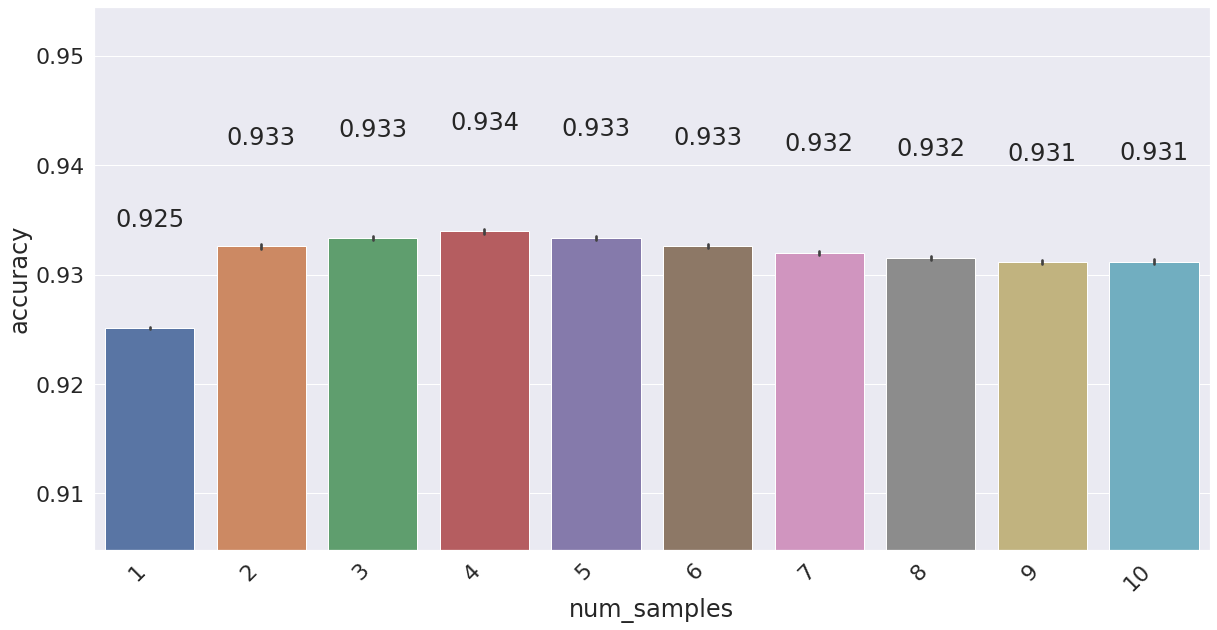

In [44]:
file_paths = []

aug_file_dir = './data/ERM_word_num_samples_experiment/averaged_sample_group/'

for file in os.listdir(aug_file_dir):
    full_path = aug_file_dir + file
    
    if full_path.split('.')[-1] == 'npy':
        print(full_path)
        file_paths.append(full_path)

create_accuracy_graph(file_paths, "bar")

In [45]:
def average_standard_augmentation_predictions(standard_file_path, augmentation_file_paths, avg_file_directory):
    with open(standard_file_path, 'rb') as standard_file:
        standard_logit_predictions = np.load(standard_file, allow_pickle = True)
        
    for aug_file_path in augmentation_file_paths:
        print(aug_file_path)
        with open(aug_file_path, 'rb') as aug_file:
            aug_logit_predictions = np.load(aug_file, allow_pickle = True)
            
            
        averaged_logit_predictions = (standard_logit_predictions + aug_logit_predictions)/2.0
        
        
        average_file_name = avg_file_directory + aug_file_path.split('/')[-1]
        
        with open(average_file_name, 'wb+') as avg_file:
            np.save(avg_file, averaged_logit_predictions)
    

def create_augmentation_impact_graph(averaged_augmentation_file_paths, plot_type = 'bar'):
    aug_to_mean_acc = []
    
    #original_accuracy = statistics.mean(calculate_accuracy('./ERM_predictions/bert.npy'))

    #print("original accuracy:", original_accuracy)
    
    for augmentation_file in averaged_augmentation_file_paths:
        accuracies = calculate_accuracy(augmentation_file)

        augmentation_name = '_'.join(augmentation_file.split('/')[-1].split('.')[0].split('_')[1:]) + "+bert" # remove '.npy' suffix in file name
        
        for accuracy in accuracies:
            aug_dict = {"augmentation":augmentation_name, "accuracy": accuracy}
            aug_to_mean_acc.append(aug_dict)
    
    acc_df = pd.DataFrame(aug_to_mean_acc).sort_values('accuracy', ascending = False)
    print(acc_df)
    
    fig, ax = plt.subplots()

    if plot_type == 'bar':
        p = sns.barplot(x = 'augmentation', y = 'accuracy', data = acc_df, ax = ax, ci = 95)
        
    elif plot_type == 'box':
        p = sns.boxplot(x = 'augmentation', y = 'accuracy', data = acc_df, ax = ax)#, order = acc_df['augmentation'])
    
    sns.set(rc = {'figure.figsize':(50,20)})
    
    min_value = acc_df.min()['accuracy']
    max_value = acc_df.max()['accuracy']

    ax.set_ylim(min_value - 0.02, min(1.0, max_value + 0.02))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    
    show_values(p)

    

    #ax.figure.set_size_inches(200,10)
    
    
    

In [48]:
aug_files = []

aug_file_dir = './data/ERM_word_num_samples_experiment/averaged_sample_group/'

for file in os.listdir(aug_file_dir):
    full_path = aug_file_dir + file
    
    if os.path.isfile(full_path) and full_path.split('.')[-1] == 'npy':
        aug_files.append(full_path)

aug_files.append('./data/ERM_predictions/bert.npy')

        
average_standard_augmentation_predictions('./data/ERM_predictions/bert.npy'
                                          , aug_files
                                          , './data/ERM_word_num_samples_experiment/averaged_with_bert/')

./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_2.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_1.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_4.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_8.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_7.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_5.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_3.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_6.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delete_num_samples_9.npy
./data/ERM_word_num_samples_experiment/averaged_sample_group/nlp_random_word_delet

In [49]:
file_paths = []
aug_file_dir = './data/ERM_word_num_samples_experiment/averaged_with_bert/'

for file in os.listdir(aug_file_dir):
    full_path = aug_file_dir + file
    
    if os.path.isfile(full_path) and full_path.split('.')[-1] == 'npy':
        aug_files.append(full_path)
        

create_augmentation_impact_graph(file_paths)

KeyError: 'accuracy'

# Experiment: Averaging Across Number of Samples Per Augmentation

In [6]:
for samples in range(1, 11):
    predict_augmented_labels('nlp_random_word_delete'
                            , num_samples = samples
                            , aug_word_min = 1
                            , aug_word_max = 1
                            , aug_word_p = 1)

num_samples: 10
char_min: 1
word_p: 1
char_min: 1
word_p: 1
nlp_random_word_delete
initialize model


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertClassifier: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertClassifier were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN t

initialization complete
generating predictions


  0%|          | 0/2091 [00:00<?, ?it/s]

writing predictions
